In [29]:
import pandas as pd
import numpy as np

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import normalize
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score

pd.set_option('display.max_columns',None)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Exploration

In [2]:
pitchers = pd.read_csv('df_pitchers.csv',index_col=0).drop('position',axis=1)

In [3]:
pitchers.head(3)

,hall,steroids,banned,first_year,overall_po,position_po,overall_a,position_a,overall_e,position_e,overall_dp,position_dp,overall_fielding_ave,position_fielding_ave,overall_range_fact,position_range_fact,w_p,l_p,w_l_p,g_p_p,gs_p,cg_p,so_p,sv_p,ipouts_p,opp_hr_ave_p,so_ave_p_p,era_p,opp_ave_p,ws_p_p,starter_bool_p,outs_per_batter_p,overall_awards,awards_pitching,war_abo_0_p,war_abo_2_p,war_abo_4_p,war_abo_6_p,war_abo_8_p,war_abo_10_p,WAR_p
brainas01,0,0,0,1871,0.536885,0.745763,0.795082,0.745763,0.717213,0.830508,0.610656,0.728814,0.530738,0.491525,0.288379,0.548965,0.842520,0.866142,0.031496,0.862205,0.874016,0.874016,0.700787,0.409449,0.866142,0.381320,0.448694,0.722222,0.383102,0.706349,0.649606,0.653200,0.054504,0.0,0.567708,0.807292,0.395833,0.427083,0.437500,0.468750,0.010417
fishech01,0,0,0,1871,0.794057,0.966102,0.870902,0.830508,0.879098,0.966102,0.806352,0.915254,0.645492,0.677966,0.326607,0.572258,0.897638,0.952756,0.043307,0.921260,0.905512,0.905512,0.826772,0.944882,0.905512,0.925234,0.834951,0.357143,0.969880,0.825397,0.649606,0.927711,0.086793,0.0,0.942708,0.932292,0.916667,0.880208,0.906250,0.468750,0.901042
mathebo01,0,0,0,1871,0.718238,0.915254,0.937500,0.949153,0.897541,1.000000,0.781762,0.898305,0.663934,0.694915,0.328707,0.566025,0.984252,1.000000,0.885827,0.992126,0.992126,0.992126,0.952756,0.870079,0.992126,0.785047,0.825243,0.341270,0.867470,0.920635,0.649606,1.000000,0.285498,0.0,0.989583,0.994792,0.958333,0.973958,0.979167,0.953125,0.979167


In [4]:
eligables = set(pd.read_csv('eligables.csv').eligables)
pitchers = pitchers[[True if p in eligables else False for p in pitchers.index]]

In [5]:
print len(pitchers)
print pitchers.hall.sum()
print pitchers.hall.sum()/float(len(pitchers))

6900
62
0.00898550724638


# Visualization

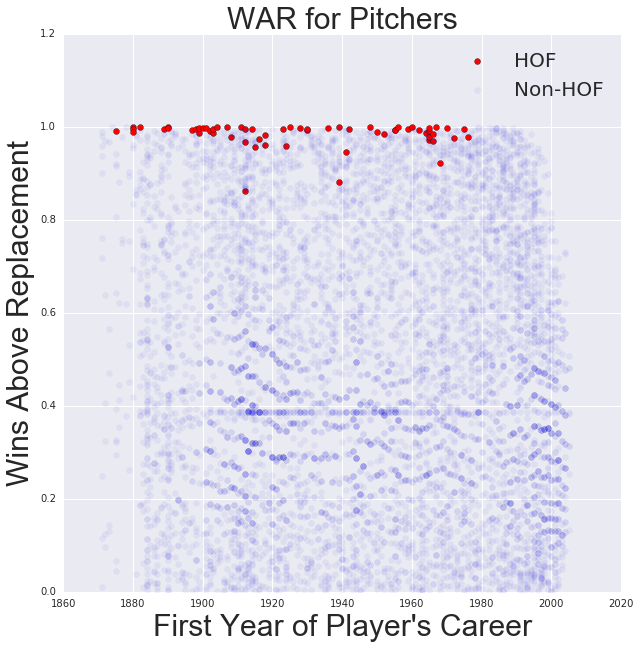

In [31]:
plt.figure(figsize=(10,10))
plt.scatter(pitchers[pitchers.hall==1].first_year,pitchers[pitchers.hall==1].loc[:,'WAR_p'],s=35,c='r',label='HOF');
plt.scatter(pitchers[pitchers.hall==0].first_year,pitchers[pitchers.hall==0].loc[:,'WAR_p'],s=35,c='b',label='Non-HOF',alpha=.05);
plt.legend(prop={'size':20});
plt.xlabel("First Year of Player's Career",fontsize=30)
plt.ylabel("Wins Above Replacement",fontsize=30)
plt.title("WAR for Pitchers",fontsize=30)
plt.ylim(0)
plt.savefig('WAR_metric.png')



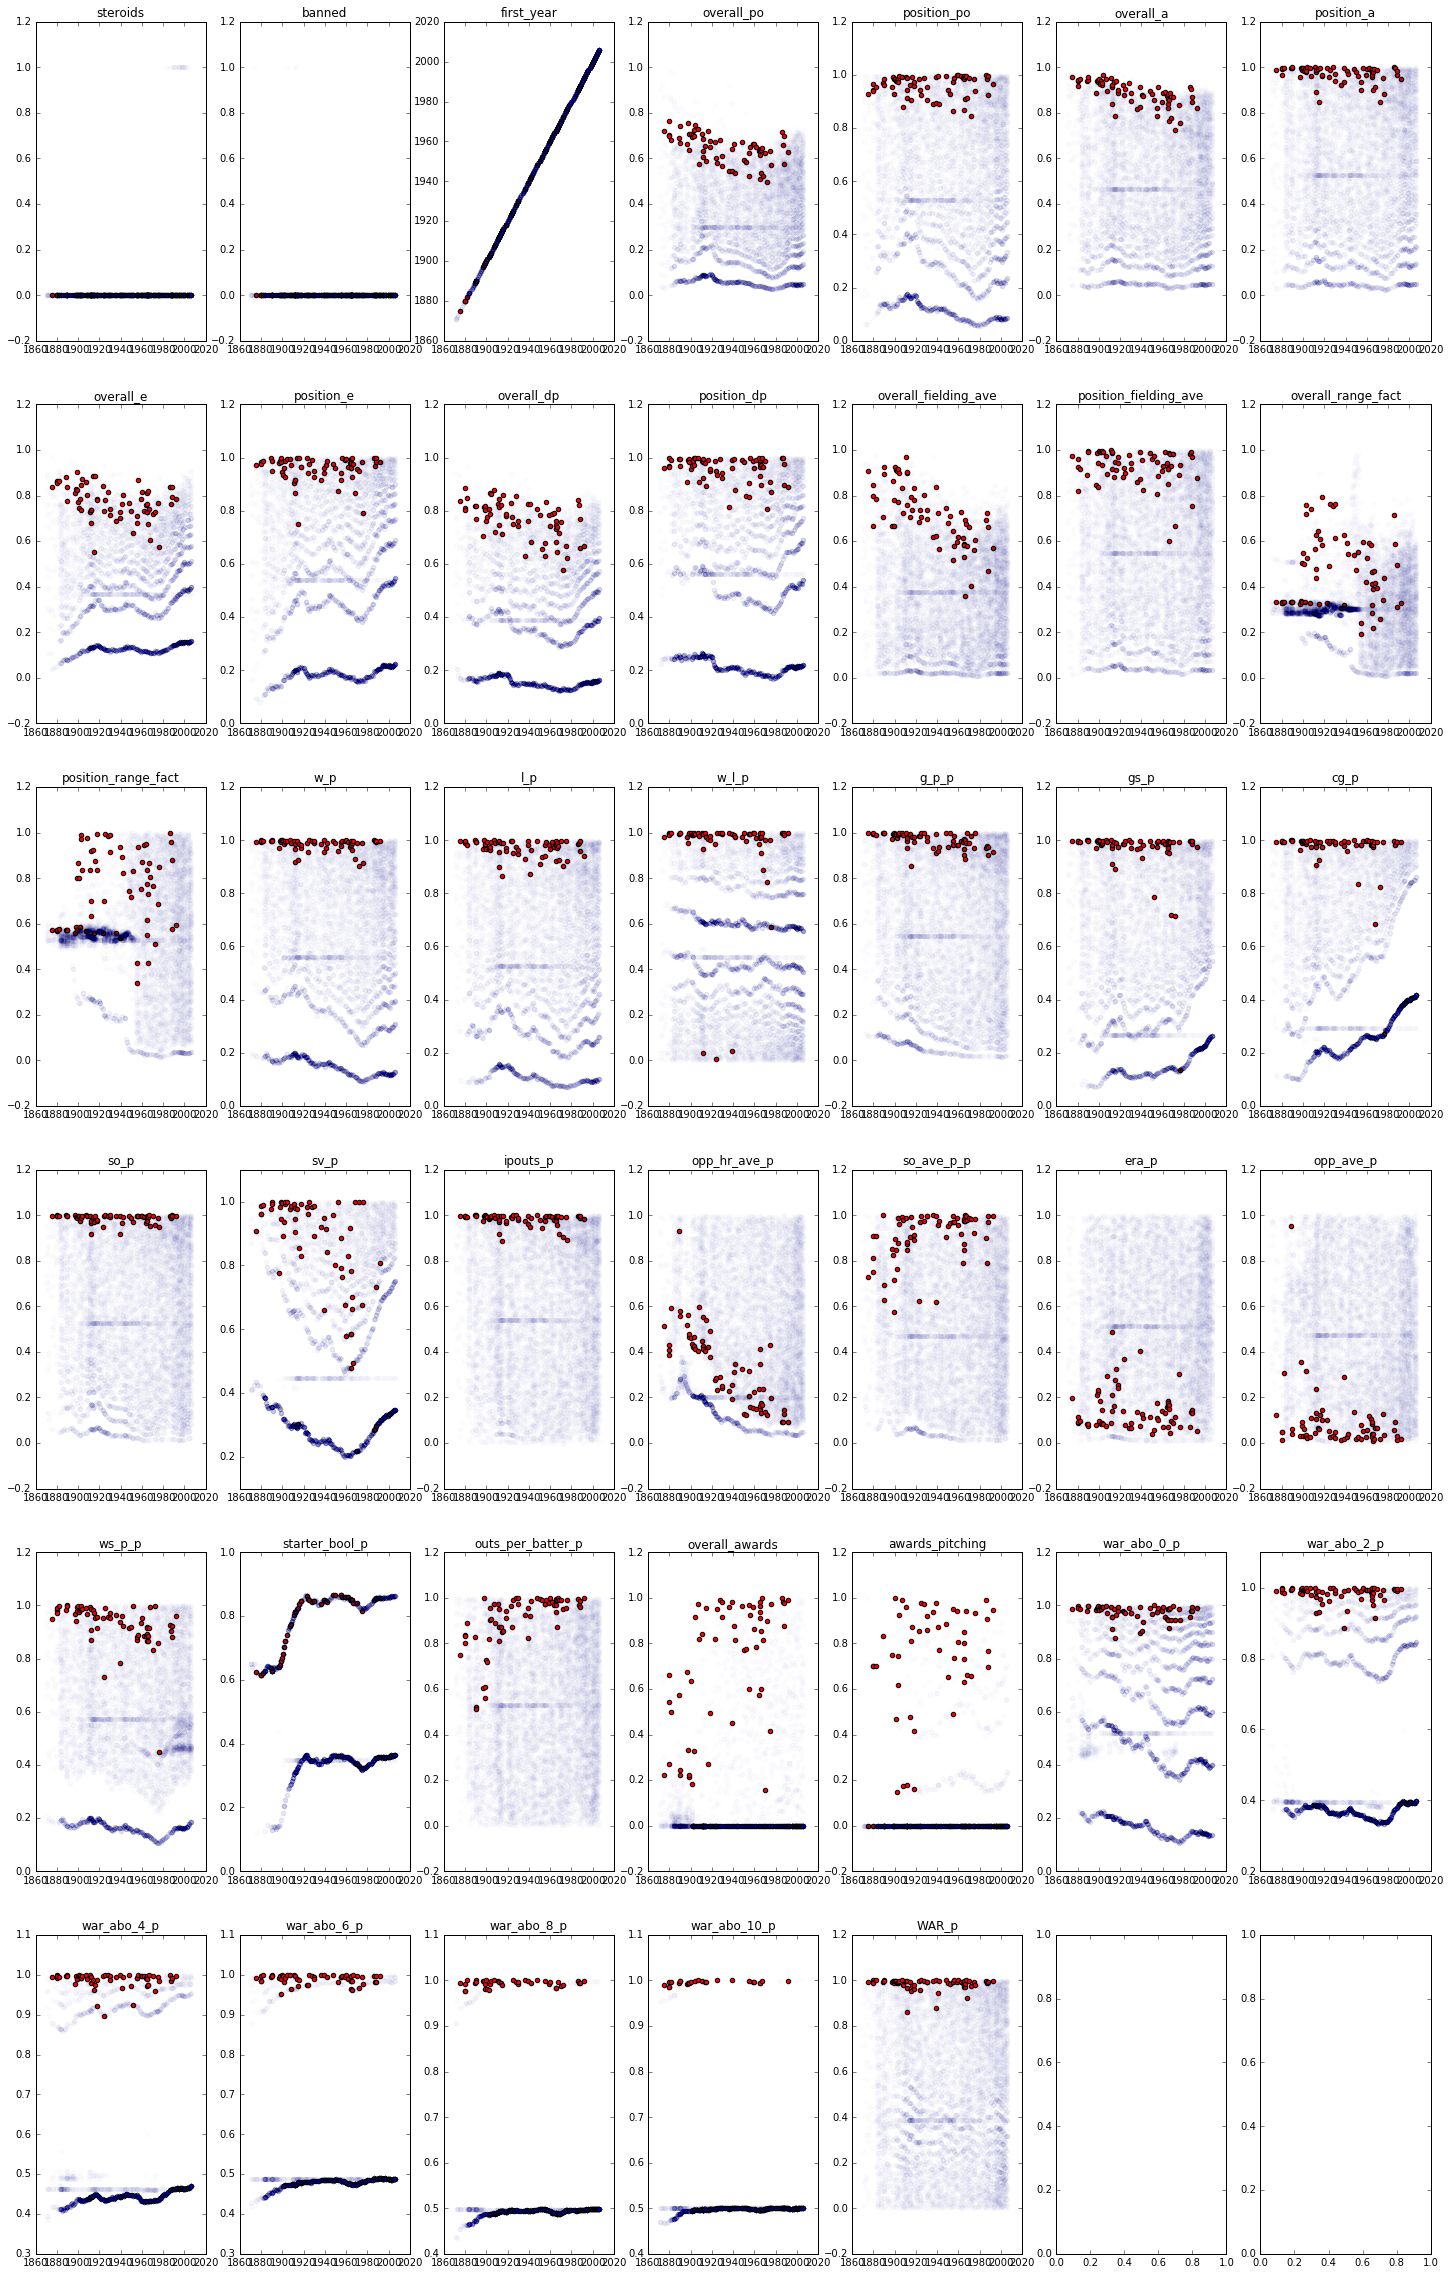

In [15]:
f, axarr = plt.subplots(6,7,figsize=(25,40));
for u,col in enumerate(pitchers.columns[1:]):
    axarr[u/7,u%7].scatter(pitchers[pitchers.hall==1].first_year,pitchers[pitchers.hall==1].loc[:,col],c='r');
    axarr[u/7,u%7].scatter(pitchers[pitchers.hall==0].first_year,pitchers[pitchers.hall==0].loc[:,col],c='b',alpha=.01);
    axarr[u/7,u%7].set_title(col);

# Modeling

In [14]:
X = pitchers.values[:,1:]
y = pitchers.values[:,0]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.3,random_state=99,stratify=y)

In [15]:
print X_train.shape,X_test.shape
## number of hall of famers
print y_train.sum(),y_test.sum()
## proportion of hall of famers
print y_train.sum()/len(y_train),y_test.sum()/len(y_test)

(4830, 40) (2070, 40)
43.0 19.0
0.00890269151139 0.00917874396135


In [21]:
rfc = RandomForestClassifier(n_estimators=1000, criterion='gini', max_depth=10, min_samples_split=5, 
                             min_samples_leaf=3, min_weight_fraction_leaf=0.0, max_features='auto', 
                             max_leaf_nodes=None, bootstrap=True, oob_score=True, n_jobs=-1, random_state=5, 
                             verbose=0, warm_start=False, class_weight=None)

In [23]:
scores = cross_val_score(rfc, X_train,y_train,scoring='average_precision', 
                cv=StratifiedShuffleSplit(y_train,n_iter=7,test_size=0.15,random_state=5), 
                n_jobs=-1, verbose=0, pre_dispatch='2*n_jobs')
print scores.mean(),scores.std(), scores.mean()-2*(scores.std()/10**.5)

0.693895771214 0.115807335308 0.620652781348


In [24]:
param_grid_knn = {'n_neighbors': range(1,30,5), 'weights': ['uniform','distance'], 'p':[1,2]}
knn = KNeighborsClassifier(n_neighbors=20, weights='distance', p=1, metric='minkowski')
grd = GridSearchCV(knn, param_grid_knn, scoring='average_precision', n_jobs=-1, 
                   cv=StratifiedShuffleSplit(y_train,n_iter=7,test_size=0.15,random_state=5))
grd.fit(X_train,y_train);

In [25]:
df = pd.DataFrame(grd.grid_scores_)
df['std_err'] = [np.std(c)/(10)**.5 for c in df.cv_validation_scores]
df['lower_bound'] = df.mean_validation_score - 2*df.std_err
for params,bound in zip(df.sort_values('lower_bound',ascending=False).parameters[:10],df.sort_values('lower_bound',ascending=False).lower_bound[:10]):
    print params,bound

{'n_neighbors': 1, 'weights': 'uniform', 'p': 1} 0.270556628934
{'n_neighbors': 1, 'weights': 'distance', 'p': 1} 0.270556628934
{'n_neighbors': 16, 'weights': 'distance', 'p': 1} 0.251200432501
{'n_neighbors': 26, 'weights': 'distance', 'p': 1} 0.24531332163
{'n_neighbors': 21, 'weights': 'distance', 'p': 1} 0.244892283344
{'n_neighbors': 6, 'weights': 'distance', 'p': 1} 0.242383798524
{'n_neighbors': 11, 'weights': 'distance', 'p': 1} 0.236946769465
{'n_neighbors': 6, 'weights': 'uniform', 'p': 1} 0.225243642786
{'n_neighbors': 6, 'weights': 'uniform', 'p': 2} 0.210467838361
{'n_neighbors': 26, 'weights': 'uniform', 'p': 1} 0.208499515312


In [13]:
X_train_n = normalize(X_train,axis=0)

In [31]:
param_grid_svm = {'kernel':['poly'], 'C': [1,4,10,17,28], 'degree':[1,2],
                  'class_weight': [{0:1,1:i} for i in range(1,40,7)]}
#{'kernel': ['rbf'], 'gamma': [1e-3,1e-4,1e-5],'C': [3,7,15,20],'class_weight': [{0:1,1:i} for i in range(1,80,15)]}
#[{'kernel': ['linear'], 'C': [25,27,30,32,35],'class_weight': [{0:1,1:i} for i in range(15,40,3)]}]

svm = SVC(C=1.0, kernel='rbf', degree=3, gamma='auto',probability=True, 
          class_weight=None, verbose=False, max_iter=1e7,random_state=5)
grd = GridSearchCV(svm, param_grid_svm, scoring='average_precision', n_jobs=-1, 
                  cv=StratifiedShuffleSplit(y_train,n_iter=7,test_size=0.15,random_state=5),verbose=5)
grd.fit(X_train,y_train);

Fitting 7 folds for each of 60 candidates, totalling 420 fits
[CV] kernel=poly, C=1, degree=1, class_weight={0: 1, 1: 1} ...........
[CV] kernel=poly, C=1, degree=1, class_weight={0: 1, 1: 1} ...........
[CV] kernel=poly, C=1, degree=1, class_weight={0: 1, 1: 1} ...........
[CV] kernel=poly, C=1, degree=1, class_weight={0: 1, 1: 1} ...........
[CV]  kernel=poly, C=1, degree=1, class_weight={0: 1, 1: 1}, score=0.490307 -   1.0s
[CV] kernel=poly, C=1, degree=1, class_weight={0: 1, 1: 1} ...........
[CV]  kernel=poly, C=1, degree=1, class_weight={0: 1, 1: 1}, score=0.577013 -   1.0s
[CV] kernel=poly, C=1, degree=1, class_weight={0: 1, 1: 1} ...........
[CV]  kernel=poly, C=1, degree=1, class_weight={0: 1, 1: 1}, score=0.656114 -   1.0s
[CV] kernel=poly, C=1, degree=1, class_weight={0: 1, 1: 1} ...........
[CV]  kernel=poly, C=1, degree=1, class_weight={0: 1, 1: 1}, score=0.859535 -   1.0s
[CV] kernel=poly, C=1, degree=2, class_weight={0: 1, 1: 1} ...........
[CV]  kernel=poly, C=1, degree

/Users/adamlevin/anaconda/lib/python2.7/site-packages/sklearn/svm/base.py:224: ConvergenceWarning: Solver terminated early (max_iter=10000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  kernel=poly, C=1, degree=1, class_weight={0: 1, 1: 1}, score=0.783971 -  11.6s
[CV] kernel=poly, C=1, degree=2, class_weight={0: 1, 1: 1} ...........


/Users/adamlevin/anaconda/lib/python2.7/site-packages/sklearn/svm/base.py:224: ConvergenceWarning: Solver terminated early (max_iter=10000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  kernel=poly, C=1, degree=2, class_weight={0: 1, 1: 1}, score=0.675365 -  11.8s


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   17.5s


[CV] kernel=poly, C=1, degree=2, class_weight={0: 1, 1: 1} ...........
[CV]  kernel=poly, C=1, degree=2, class_weight={0: 1, 1: 1}, score=0.796706 -   3.7s
[CV] kernel=poly, C=1, degree=1, class_weight={0: 1, 1: 8} ...........


/Users/adamlevin/anaconda/lib/python2.7/site-packages/sklearn/svm/base.py:224: ConvergenceWarning: Solver terminated early (max_iter=10000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  kernel=poly, C=1, degree=2, class_weight={0: 1, 1: 1}, score=0.915662 -  12.0s
[CV] kernel=poly, C=1, degree=1, class_weight={0: 1, 1: 8} ...........
[CV]  kernel=poly, C=1, degree=1, class_weight={0: 1, 1: 8}, score=0.624422 -   1.5s
[CV] kernel=poly, C=1, degree=1, class_weight={0: 1, 1: 8} ...........
[CV]  kernel=poly, C=1, degree=1, class_weight={0: 1, 1: 8}, score=0.586322 -   1.4s
[CV] kernel=poly, C=1, degree=1, class_weight={0: 1, 1: 8} ...........
[CV]  kernel=poly, C=1, degree=1, class_weight={0: 1, 1: 8}, score=0.634931 -   1.5s
[CV] kernel=poly, C=1, degree=1, class_weight={0: 1, 1: 8} ...........
[CV]  kernel=poly, C=1, degree=1, class_weight={0: 1, 1: 8}, score=0.646505 -   1.6s
[CV] kernel=poly, C=1, degree=1, class_weight={0: 1, 1: 8} ...........
[CV]  kernel=poly, C=1, degree=1, class_weight={0: 1, 1: 8}, score=0.771288 -   1.4s
[CV] kernel=poly, C=1, degree=1, class_weight={0: 1, 1: 8} ...........
[CV]  kernel=poly, C=1, degree=1, class_weight={0: 1, 1: 8}, sco

/Users/adamlevin/anaconda/lib/python2.7/site-packages/sklearn/svm/base.py:224: ConvergenceWarning: Solver terminated early (max_iter=10000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  kernel=poly, C=1, degree=1, class_weight={0: 1, 1: 1}, score=0.674863 - 1.5min
[CV] kernel=poly, C=1, degree=1, class_weight={0: 1, 1: 15} ..........
[CV]  kernel=poly, C=1, degree=2, class_weight={0: 1, 1: 1}, score=0.343169 - 1.5min
[CV] kernel=poly, C=1, degree=1, class_weight={0: 1, 1: 15} ..........
[CV]  kernel=poly, C=1, degree=1, class_weight={0: 1, 1: 15}, score=0.877453 -   1.8s
[CV] kernel=poly, C=1, degree=1, class_weight={0: 1, 1: 15} ..........
[CV]  kernel=poly, C=1, degree=1, class_weight={0: 1, 1: 15}, score=0.731474 -   1.6s
[CV] kernel=poly, C=1, degree=1, class_weight={0: 1, 1: 15} ..........
[CV]  kernel=poly, C=1, degree=1, class_weight={0: 1, 1: 15}, score=0.233797 - 6.2min
[CV] kernel=poly, C=1, degree=2, class_weight={0: 1, 1: 15} ..........
[CV]  kernel=poly, C=1, degree=2, class_weight={0: 1, 1: 15}, score=0.476031 -   3.9s
[CV] kernel=poly, C=1, degree=2, class_weight={0: 1, 1: 15} ..........
[CV]  kernel=poly, C=1, degree=2, class_weight={0: 1, 1: 15}

KeyboardInterrupt: 

{'kernel': 'rbf', 'C': 15, 'gamma': 0.0001, 'class_weight': {0: 1, 1: 31}} no normalization 0.596851831865
{'kernel': 'rbf', 'C': 15, 'gamma': 0.001, 'class_weight': {0: 1, 1: 1}} with normalization 0.569109350701
{'kernel': 'linear', 'C': 0.5, 'class_weight': {0: 1, 1: 17}} no normalization - 0.63
{'kernel': 'linear', 'C': 35, 'class_weight': {0: 1, 1: 21}} with normalization - 0.60472025404
{'kernel': 'poly', 'C': 1, 'degree': 2, 'class_weight': {0: 1, 1: 1}} with normalization 0.563615276158

In [30]:
df = pd.DataFrame(grd.grid_scores_)
df['std_err'] = [np.std(c)/(10)**.5 for c in df.cv_validation_scores]
df['lower_bound'] = df.mean_validation_score - 2*df.std_err
for params,bound in zip(df.sort_values('lower_bound',ascending=False).parameters[:10],df.sort_values('lower_bound',ascending=False).lower_bound[:10]):
    print params,bound

{'kernel': 'poly', 'C': 1, 'degree': 2, 'class_weight': {0: 1, 1: 1}} 0.563615276158
{'kernel': 'poly', 'C': 1, 'degree': 1, 'class_weight': {0: 1, 1: 1}} 0.548986789004
{'kernel': 'poly', 'C': 28, 'degree': 2, 'class_weight': {0: 1, 1: 29}} 0.516544704977
{'kernel': 'poly', 'C': 17, 'degree': 2, 'class_weight': {0: 1, 1: 29}} 0.516544704977
{'kernel': 'poly', 'C': 10, 'degree': 2, 'class_weight': {0: 1, 1: 29}} 0.516544704977
{'kernel': 'poly', 'C': 1, 'degree': 2, 'class_weight': {0: 1, 1: 29}} 0.516544704977
{'kernel': 'poly', 'C': 4, 'degree': 2, 'class_weight': {0: 1, 1: 29}} 0.516544704977
{'kernel': 'poly', 'C': 1, 'degree': 2, 'class_weight': {0: 1, 1: 36}} 0.516373532218
{'kernel': 'poly', 'C': 17, 'degree': 2, 'class_weight': {0: 1, 1: 36}} 0.516373532218
{'kernel': 'poly', 'C': 10, 'degree': 2, 'class_weight': {0: 1, 1: 36}} 0.516373532218


In [35]:
param_grid_lgr = [{'C': [1, 5, 15],
                   'class_weight': [{0:1,1:i} for i in range(1,40,10)]}]
lgr = LogisticRegression(penalty='l1', dual=False, tol=0.0001, C=1.0, fit_intercept=True, 
                         intercept_scaling=1, class_weight=None, random_state=5, solver='liblinear', 
                         max_iter=10000, multi_class='ovr', verbose=5, warm_start=False, n_jobs=-1)
grd = GridSearchCV(lgr, param_grid_lgr,scoring='average_precision',n_jobs=-1,
                   cv=StratifiedShuffleSplit(y_train,n_iter=7,test_size=0.15,random_state=5),verbose=5)
grd.fit(X_train,y_train);

Fitting 7 folds for each of 12 candidates, totalling 84 fits
[CV] C=1, class_weight={0: 1, 1: 1} ..................................
[CV] C=1, class_weight={0: 1, 1: 1} ..................................
[CV] C=1, class_weight={0: 1, 1: 1} ..................................
[CV] C=1, class_weight={0: 1, 1: 1} ..................................
[LibLinear][CV] ......... C=1, class_weight={0: 1, 1: 1}, score=0.657555 -   0.5s
[CV] C=1, class_weight={0: 1, 1: 1} ..................................
[LibLinear][CV] ......... C=1, class_weight={0: 1, 1: 1}, score=0.492690 -   0.7s
[CV] C=1, class_weight={0: 1, 1: 1} ..................................
[LibLinear][CV] ......... C=1, class_weight={0: 1, 1: 1}, score=0.631518 -   0.8s
[CV] C=1, class_weight={0: 1, 1: 1} ..................................
[LibLinear][CV] ......... C=1, class_weight={0: 1, 1: 1}, score=0.664846 -   0.9s
[CV] C=1, class_weight={0: 1, 1: 11} .................................
[LibLinear][CV] ......... C=1, class_weight

[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.4s


[LibLinear][CV] ........ C=1, class_weight={0: 1, 1: 11}, score=0.574302 -   4.2s
[CV] C=1, class_weight={0: 1, 1: 21} .................................
[LibLinear][CV] ........ C=1, class_weight={0: 1, 1: 11}, score=0.751504 -   4.2s
[CV] C=1, class_weight={0: 1, 1: 21} .................................
[LibLinear][CV] ........ C=1, class_weight={0: 1, 1: 11}, score=0.602088 -   3.9s
[CV] C=1, class_weight={0: 1, 1: 21} .................................
[LibLinear][CV] ........ C=1, class_weight={0: 1, 1: 11}, score=0.710604 -   4.9s
[CV] C=1, class_weight={0: 1, 1: 21} .................................
[LibLinear][CV] ........ C=1, class_weight={0: 1, 1: 21}, score=0.500336 -   6.1s
[CV] C=1, class_weight={0: 1, 1: 21} .................................
[LibLinear][CV] ........ C=1, class_weight={0: 1, 1: 21}, score=0.522521 -   8.1s
[CV] C=1, class_weight={0: 1, 1: 21} .................................
[LibLinear][CV] ........ C=1, class_weight={0: 1, 1: 21}, score=0.528744 -   8.7s


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  3.8min


[LibLinear][CV] ....... C=15, class_weight={0: 1, 1: 11}, score=0.556942 -  31.3s
[CV] C=15, class_weight={0: 1, 1: 11} ................................
[LibLinear][CV] ....... C=15, class_weight={0: 1, 1: 11}, score=0.448259 -  30.7s
[CV] C=15, class_weight={0: 1, 1: 11} ................................
[LibLinear][CV] ....... C=15, class_weight={0: 1, 1: 11}, score=0.567793 -  38.1s
[CV] C=15, class_weight={0: 1, 1: 21} ................................
[LibLinear][CV] ....... C=15, class_weight={0: 1, 1: 11}, score=0.519593 -  20.6s
[CV] C=15, class_weight={0: 1, 1: 21} ................................
[LibLinear][CV] ....... C=15, class_weight={0: 1, 1: 11}, score=0.696159 -  21.6s
[CV] C=15, class_weight={0: 1, 1: 21} ................................
[LibLinear][CV] ....... C=15, class_weight={0: 1, 1: 21}, score=0.512479 -  38.4s
[CV] C=15, class_weight={0: 1, 1: 21} ................................
[LibLinear][CV] ....... C=15, class_weight={0: 1, 1: 11}, score=0.904699 - 1.4min


[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed:  8.4min finished


[LibLinear]

In [36]:
df = pd.DataFrame(grd.grid_scores_)
df['std_err'] = [np.std(c)/(10)**.5 for c in df.cv_validation_scores]
df['lower_bound'] = df.mean_validation_score - 2*df.std_err
for params,bound in zip(df.sort_values('lower_bound',ascending=False).parameters[:10],df.sort_values('lower_bound',ascending=False).lower_bound[:10]):
    print params,bound

{'C': 1, 'class_weight': {0: 1, 1: 1}} 0.622992377943
{'C': 5, 'class_weight': {0: 1, 1: 1}} 0.603129669949
{'C': 1, 'class_weight': {0: 1, 1: 11}} 0.560135071047
{'C': 15, 'class_weight': {0: 1, 1: 1}} 0.555976445513
{'C': 5, 'class_weight': {0: 1, 1: 11}} 0.536270760138
{'C': 1, 'class_weight': {0: 1, 1: 21}} 0.524290457724
{'C': 5, 'class_weight': {0: 1, 1: 21}} 0.519964756225
{'C': 15, 'class_weight': {0: 1, 1: 11}} 0.508845741949
{'C': 1, 'class_weight': {0: 1, 1: 31}} 0.499070303555
{'C': 5, 'class_weight': {0: 1, 1: 31}} 0.467825007047


In [32]:
param_grid_gbc = [{'n_estimators':range(10,100,10)}]
gbc = GradientBoostingClassifier(loss='deviance', learning_rate=0.05, n_estimators=60, 
                                 subsample=.8, min_samples_split=20, min_samples_leaf=3, 
                                 min_weight_fraction_leaf=0.0, max_depth=8, 
                                 random_state=5, max_features=None, verbose=0)
grd = GridSearchCV(gbc, param_grid_gbc, scoring='average_precision', n_jobs=-1, 
                   cv=StratifiedShuffleSplit(y_train,n_iter=7,test_size=0.15,random_state=5))
grd.fit(X_train,y_train);

In [33]:
df = pd.DataFrame(grd.grid_scores_)
df['std_err'] = [np.std(c)/(10)**.5 for c in df.cv_validation_scores]
df['lower_bound'] = df.mean_validation_score - 2*df.std_err
for params,bound in zip(df.sort_values('lower_bound',ascending=False).parameters[:10],df.sort_values('lower_bound',ascending=False).lower_bound[:10]):
    print params,bound

{'n_estimators': 50} 0.447207364113
{'n_estimators': 90} 0.4448558716
{'n_estimators': 80} 0.437887987285
{'n_estimators': 60} 0.437143548863
{'n_estimators': 70} 0.436662144865
{'n_estimators': 40} 0.430955344563
{'n_estimators': 30} 0.429687389151
{'n_estimators': 20} 0.417158311523
{'n_estimators': 10} 0.402205278652


In [37]:
param_grid_gbc = [{'min_samples_split':[1,3,5,9,14],
                   'max_depth':[3,5,7,9,11]}]
gbc = GradientBoostingClassifier(loss='deviance', learning_rate=0.05, n_estimators=50, 
                                 subsample=.8, min_samples_split=20, min_samples_leaf=3, 
                                 min_weight_fraction_leaf=0.0, max_depth=8, 
                                 random_state=5, max_features=None, verbose=0)
grd = GridSearchCV(gbc, param_grid_gbc, scoring='average_precision', n_jobs=-1, 
             iid=True, refit=True, cv=StratifiedShuffleSplit(y_train,n_iter=7,test_size=0.15,random_state=5),
             verbose=5, pre_dispatch='2*n_jobs', error_score='raise')
grd.fit(X_train,y_train);

Fitting 7 folds for each of 25 candidates, totalling 175 fits
[CV] min_samples_split=1, max_depth=3 ................................
[CV] min_samples_split=1, max_depth=3 ................................
[CV] min_samples_split=1, max_depth=3 ................................
[CV] min_samples_split=1, max_depth=3 ................................
[CV] ....... min_samples_split=1, max_depth=3, score=0.476724 -   1.2s
[CV] min_samples_split=1, max_depth=3 ................................
[CV] ....... min_samples_split=1, max_depth=3, score=0.706189 -   1.2s
[CV] ....... min_samples_split=1, max_depth=3, score=0.448453 -   1.2s
[CV] min_samples_split=1, max_depth=3 ................................
[CV] min_samples_split=1, max_depth=3 ................................
[CV] ....... min_samples_split=1, max_depth=3, score=0.604677 -   1.2s
[CV] min_samples_split=3, max_depth=3 ................................
[CV] ....... min_samples_split=1, max_depth=3, score=0.507299 -   1.1s
[CV] min_sample

[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.7s


[CV] ....... min_samples_split=3, max_depth=3, score=0.656672 -   1.1s
[CV] ....... min_samples_split=3, max_depth=3, score=0.365384 -   1.1s
[CV] ....... min_samples_split=5, max_depth=3, score=0.476724 -   1.1s
[CV] ....... min_samples_split=5, max_depth=3, score=0.448453 -   1.1s
[CV] min_samples_split=5, max_depth=3 ................................
[CV] min_samples_split=5, max_depth=3 ................................
[CV] min_samples_split=5, max_depth=3 ................................
[CV] min_samples_split=5, max_depth=3 ................................
[CV] ....... min_samples_split=5, max_depth=3, score=0.604677 -   1.1s
[CV] ....... min_samples_split=5, max_depth=3, score=0.507299 -   1.1s
[CV] ....... min_samples_split=5, max_depth=3, score=0.706189 -   1.1s
[CV] min_samples_split=5, max_depth=3 ................................
[CV] ....... min_samples_split=5, max_depth=3, score=0.365384 -   1.1s
[CV] min_samples_split=9, max_depth=3 ................................
[CV] m

[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   24.2s


[CV] ...... min_samples_split=14, max_depth=5, score=0.446677 -   1.7s
[CV] min_samples_split=14, max_depth=5 ...............................
[CV] ...... min_samples_split=14, max_depth=5, score=0.553658 -   1.7s
[CV] ...... min_samples_split=14, max_depth=5, score=0.721887 -   1.7s
[CV] min_samples_split=14, max_depth=5 ...............................
[CV] min_samples_split=1, max_depth=7 ................................
[CV] ...... min_samples_split=14, max_depth=5, score=0.780057 -   1.7s
[CV] min_samples_split=1, max_depth=7 ................................
[CV] ...... min_samples_split=14, max_depth=5, score=0.289684 -   1.7s
[CV] min_samples_split=1, max_depth=7 ................................
[CV] ...... min_samples_split=14, max_depth=5, score=0.461447 -   1.7s
[CV] min_samples_split=1, max_depth=7 ................................
[CV] ....... min_samples_split=1, max_depth=7, score=0.429619 -   2.4s
[CV] min_samples_split=1, max_depth=7 ................................
[CV] .

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.4min


[CV] ...... min_samples_split=5, max_depth=11, score=0.375343 -   3.4s
[CV] min_samples_split=5, max_depth=11 ...............................
[CV] ...... min_samples_split=5, max_depth=11, score=0.539233 -   3.4s
[CV] min_samples_split=5, max_depth=11 ...............................
[CV] ...... min_samples_split=5, max_depth=11, score=0.446752 -   3.5s
[CV] min_samples_split=5, max_depth=11 ...............................
[CV] ...... min_samples_split=5, max_depth=11, score=0.669738 -   3.4s
[CV] min_samples_split=9, max_depth=11 ...............................
[CV] ...... min_samples_split=5, max_depth=11, score=0.542000 -   3.3s
[CV] min_samples_split=9, max_depth=11 ...............................
[CV] ...... min_samples_split=5, max_depth=11, score=0.268659 -   3.2s
[CV] min_samples_split=9, max_depth=11 ...............................
[CV] ...... min_samples_split=5, max_depth=11, score=0.505638 -   3.2s
[CV] min_samples_split=9, max_depth=11 ...............................
[CV] .

[Parallel(n_jobs=-1)]: Done 175 out of 175 | elapsed:  1.7min finished


In [38]:
df = pd.DataFrame(grd.grid_scores_)
df['std_err'] = [np.std(c)/(10)**.5 for c in df.cv_validation_scores]
df['lower_bound'] = df.mean_validation_score - 2*df.std_err
for params,bound in zip(df.sort_values('lower_bound',ascending=False).parameters[:10],df.sort_values('lower_bound',ascending=False).lower_bound[:10]):
    print params,bound

{'min_samples_split': 14, 'max_depth': 3} 0.482077503584
{'min_samples_split': 9, 'max_depth': 3} 0.471481109539
{'min_samples_split': 1, 'max_depth': 3} 0.466468083539
{'min_samples_split': 5, 'max_depth': 3} 0.466468083539
{'min_samples_split': 3, 'max_depth': 3} 0.466468083539
{'min_samples_split': 9, 'max_depth': 5} 0.447173787176
{'min_samples_split': 14, 'max_depth': 7} 0.439816852637
{'min_samples_split': 9, 'max_depth': 11} 0.431459883956
{'min_samples_split': 14, 'max_depth': 11} 0.430463029156
{'min_samples_split': 14, 'max_depth': 9} 0.42395761929


In [39]:
param_grid_gbc = [{'min_samples_split':[1,3,5,7],
                   'min_samples_leaf':[1,3,5,7,9,11]}]
gbc = GradientBoostingClassifier(loss='deviance', learning_rate=0.05, n_estimators=50, 
                                 subsample=.8, min_samples_split=10, min_samples_leaf=3, 
                                 max_depth=3, random_state=5, max_features=None, verbose=0)
grd = GridSearchCV(gbc, param_grid_gbc, scoring='average_precision', n_jobs=-1, 
                   cv=StratifiedShuffleSplit(y_train,n_iter=7,test_size=0.15,random_state=5),verbose=5)
grd.fit(X_train,y_train);

Fitting 7 folds for each of 24 candidates, totalling 168 fits
[CV] min_samples_split=1, min_samples_leaf=1 .........................
[CV] min_samples_split=1, min_samples_leaf=1 .........................
[CV] min_samples_split=1, min_samples_leaf=1 .........................
[CV] min_samples_split=1, min_samples_leaf=1 .........................
[CV]  min_samples_split=1, min_samples_leaf=1, score=0.429697 -   1.1s
[CV] min_samples_split=1, min_samples_leaf=1 .........................
[CV]  min_samples_split=1, min_samples_leaf=1, score=0.324432 -   1.2s
[CV]  min_samples_split=1, min_samples_leaf=1, score=0.717031 -   1.2s
[CV] min_samples_split=1, min_samples_leaf=1 .........................
[CV] min_samples_split=1, min_samples_leaf=1 .........................
[CV]  min_samples_split=1, min_samples_leaf=1, score=0.255955 -   1.2s
[CV] min_samples_split=3, min_samples_leaf=1 .........................
[CV]  min_samples_split=1, min_samples_leaf=1, score=0.802239 -   1.2s
[CV]  min_sampl

[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.0s


[CV]  min_samples_split=3, min_samples_leaf=1, score=0.409473 -   1.2s
[CV] min_samples_split=5, min_samples_leaf=1 .........................
[CV]  min_samples_split=3, min_samples_leaf=1, score=0.686832 -   1.1s
[CV]  min_samples_split=5, min_samples_leaf=1, score=0.453107 -   1.1s
[CV] min_samples_split=5, min_samples_leaf=1 .........................
[CV] min_samples_split=5, min_samples_leaf=1 .........................
[CV]  min_samples_split=5, min_samples_leaf=1, score=0.527965 -   1.1s
[CV] min_samples_split=5, min_samples_leaf=1 .........................
[CV]  min_samples_split=5, min_samples_leaf=1, score=0.262984 -   1.1s
[CV]  min_samples_split=5, min_samples_leaf=1, score=0.631799 -   1.1s
[CV] min_samples_split=5, min_samples_leaf=1 .........................
[CV] min_samples_split=7, min_samples_leaf=1 .........................
[CV]  min_samples_split=5, min_samples_leaf=1, score=0.435277 -   1.1s
[CV] min_samples_split=7, min_samples_leaf=1 .........................
[CV]  

[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   19.2s


[CV]  min_samples_split=3, min_samples_leaf=5, score=0.417504 -   1.1s
[CV] min_samples_split=3, min_samples_leaf=5 .........................
[CV]  min_samples_split=3, min_samples_leaf=5, score=0.712234 -   1.1s
[CV] min_samples_split=3, min_samples_leaf=5 .........................
[CV]  min_samples_split=3, min_samples_leaf=5, score=0.628553 -   1.1s
[CV] min_samples_split=5, min_samples_leaf=5 .........................
[CV]  min_samples_split=3, min_samples_leaf=5, score=0.824571 -   1.1s
[CV] min_samples_split=5, min_samples_leaf=5 .........................
[CV]  min_samples_split=3, min_samples_leaf=5, score=0.453194 -   1.1s
[CV] min_samples_split=5, min_samples_leaf=5 .........................
[CV]  min_samples_split=3, min_samples_leaf=5, score=0.640716 -   1.1s
[CV] min_samples_split=5, min_samples_leaf=5 .........................
[CV]  min_samples_split=5, min_samples_leaf=5, score=0.447844 -   1.2s
[CV] min_samples_split=5, min_samples_leaf=5 .........................
[CV]  

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   45.7s


[CV]  min_samples_split=5, min_samples_leaf=11, score=0.749760 -   1.2s
[CV] min_samples_split=5, min_samples_leaf=11 ........................
[CV]  min_samples_split=5, min_samples_leaf=11, score=0.553338 -   1.1s
[CV] min_samples_split=7, min_samples_leaf=11 ........................
[CV]  min_samples_split=5, min_samples_leaf=11, score=0.819505 -   1.1s
[CV] min_samples_split=7, min_samples_leaf=11 ........................
[CV]  min_samples_split=5, min_samples_leaf=11, score=0.512199 -   1.2s
[CV] min_samples_split=7, min_samples_leaf=11 ........................
[CV]  min_samples_split=7, min_samples_leaf=11, score=0.487416 -   1.1s
[CV]  min_samples_split=5, min_samples_leaf=11, score=0.598985 -   1.1s
[CV] min_samples_split=7, min_samples_leaf=11 ........................
[CV] min_samples_split=7, min_samples_leaf=11 ........................
[CV]  min_samples_split=7, min_samples_leaf=11, score=0.539159 -   1.1s
[CV] min_samples_split=7, min_samples_leaf=11 ........................

[Parallel(n_jobs=-1)]: Done 168 out of 168 | elapsed:   49.3s finished


In [40]:
df = pd.DataFrame(grd.grid_scores_)
df['std_err'] = [np.std(c)/(10)**.5 for c in df.cv_validation_scores]
df['lower_bound'] = df.mean_validation_score - 2*df.std_err
for params,bound in zip(df.sort_values('lower_bound',ascending=False).parameters[:10],df.sort_values('lower_bound',ascending=False).lower_bound[:10]):
    print params,bound

{'min_samples_split': 7, 'min_samples_leaf': 9} 0.564683357734
{'min_samples_split': 5, 'min_samples_leaf': 9} 0.564683357734
{'min_samples_split': 3, 'min_samples_leaf': 9} 0.564683357734
{'min_samples_split': 1, 'min_samples_leaf': 9} 0.564683357734
{'min_samples_split': 1, 'min_samples_leaf': 7} 0.542113943079
{'min_samples_split': 3, 'min_samples_leaf': 7} 0.542113943079
{'min_samples_split': 7, 'min_samples_leaf': 7} 0.542113943079
{'min_samples_split': 5, 'min_samples_leaf': 7} 0.542113943079
{'min_samples_split': 5, 'min_samples_leaf': 11} 0.534421156147
{'min_samples_split': 3, 'min_samples_leaf': 11} 0.534421156147


In [51]:
param_grid_gbc = [{'max_features':['sqrt','log2',None],
                   'min_samples_split':[3,5,7,9],
                   'max_depth':[3,5,7,9],
                   'n_estimators':[100,150,200,250,300]}]
gbc = GradientBoostingClassifier(loss='deviance', learning_rate=0.01, n_estimators=50, 
                                 subsample=.8, min_samples_split=7, min_samples_leaf=3, 
                                 max_depth=3, random_state=5, max_features=None, verbose=0)
grd = GridSearchCV(gbc, param_grid_gbc, scoring='average_precision', n_jobs=-1, 
                   cv=StratifiedShuffleSplit(y_train,n_iter=7,test_size=0.15,random_state=5),verbose=5)
grd.fit(X_train,y_train);

Fitting 7 folds for each of 240 candidates, totalling 1680 fits
[CV] max_features=sqrt, min_samples_split=3, n_estimators=100, max_depth=3 
[CV] max_features=sqrt, min_samples_split=3, n_estimators=100, max_depth=3 
[CV] max_features=sqrt, min_samples_split=3, n_estimators=100, max_depth=3 
[CV] max_features=sqrt, min_samples_split=3, n_estimators=100, max_depth=3 
[CV]  max_features=sqrt, min_samples_split=3, n_estimators=100, max_depth=3, score=0.540405 -   0.6s
[CV]  max_features=sqrt, min_samples_split=3, n_estimators=100, max_depth=3, score=0.588110 -   0.6s
[CV] max_features=sqrt, min_samples_split=3, n_estimators=100, max_depth=3 
[CV] max_features=sqrt, min_samples_split=3, n_estimators=100, max_depth=3 
[CV]  max_features=sqrt, min_samples_split=3, n_estimators=100, max_depth=3, score=0.899505 -   0.7s
[CV] max_features=sqrt, min_samples_split=3, n_estimators=100, max_depth=3 
[CV]  max_features=sqrt, min_samples_split=3, n_estimators=100, max_depth=3, score=0.688903 -   0.7s


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.5s


[CV]  max_features=sqrt, min_samples_split=3, n_estimators=150, max_depth=3, score=0.828568 -   0.9s
[CV] max_features=sqrt, min_samples_split=3, n_estimators=200, max_depth=3 
[CV]  max_features=sqrt, min_samples_split=3, n_estimators=150, max_depth=3, score=0.472424 -   1.0s
[CV] max_features=sqrt, min_samples_split=3, n_estimators=200, max_depth=3 
[CV]  max_features=sqrt, min_samples_split=3, n_estimators=150, max_depth=3, score=0.711714 -   0.9s
[CV] max_features=sqrt, min_samples_split=3, n_estimators=200, max_depth=3 
[CV]  max_features=sqrt, min_samples_split=3, n_estimators=200, max_depth=3, score=0.535156 -   1.3s
[CV] max_features=sqrt, min_samples_split=3, n_estimators=200, max_depth=3 
[CV]  max_features=sqrt, min_samples_split=3, n_estimators=200, max_depth=3, score=0.595936 -   1.2s
[CV] max_features=sqrt, min_samples_split=3, n_estimators=200, max_depth=3 
[CV]  max_features=sqrt, min_samples_split=3, n_estimators=200, max_depth=3, score=0.854533 -   1.2s
[CV] max_featu

[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   20.3s


[CV]  max_features=sqrt, min_samples_split=5, n_estimators=300, max_depth=3, score=0.496770 -   1.8s
[CV] max_features=sqrt, min_samples_split=5, n_estimators=300, max_depth=3 
[CV]  max_features=sqrt, min_samples_split=5, n_estimators=300, max_depth=3, score=0.854533 -   1.8s
[CV] max_features=sqrt, min_samples_split=5, n_estimators=300, max_depth=3 
[CV]  max_features=sqrt, min_samples_split=5, n_estimators=300, max_depth=3, score=0.691136 -   1.7s
[CV] max_features=sqrt, min_samples_split=7, n_estimators=100, max_depth=3 
[CV]  max_features=sqrt, min_samples_split=5, n_estimators=300, max_depth=3, score=0.827140 -   1.7s
[CV] max_features=sqrt, min_samples_split=7, n_estimators=100, max_depth=3 
[CV]  max_features=sqrt, min_samples_split=7, n_estimators=100, max_depth=3, score=0.535241 -   0.6s
[CV] max_features=sqrt, min_samples_split=7, n_estimators=100, max_depth=3 
[CV]  max_features=sqrt, min_samples_split=7, n_estimators=100, max_depth=3, score=0.610212 -   0.6s
[CV] max_featu

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   46.1s


[CV]  max_features=log2, min_samples_split=3, n_estimators=200, max_depth=3, score=0.546217 -   1.1s
[CV] max_features=log2, min_samples_split=3, n_estimators=200, max_depth=3 
[CV]  max_features=log2, min_samples_split=3, n_estimators=200, max_depth=3, score=0.614458 -   1.1s
[CV]  max_features=log2, min_samples_split=3, n_estimators=200, max_depth=3, score=0.865041 -   1.1s
[CV]  max_features=log2, min_samples_split=3, n_estimators=200, max_depth=3, score=0.650505 -   1.0s
[CV]  max_features=log2, min_samples_split=3, n_estimators=200, max_depth=3, score=0.803812 -   0.8s
[CV] max_features=log2, min_samples_split=3, n_estimators=200, max_depth=3 
[CV] max_features=log2, min_samples_split=3, n_estimators=200, max_depth=3 
[CV] max_features=log2, min_samples_split=3, n_estimators=250, max_depth=3 
[CV] max_features=log2, min_samples_split=3, n_estimators=250, max_depth=3 
[CV]  max_features=log2, min_samples_split=3, n_estimators=200, max_depth=3, score=0.558799 -   1.0s
[CV]  max_feat

[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  1.4min


[CV]  max_features=None, min_samples_split=3, n_estimators=100, max_depth=3, score=0.562084 -   3.2s
[CV] max_features=None, min_samples_split=3, n_estimators=100, max_depth=3 
[CV]  max_features=None, min_samples_split=3, n_estimators=100, max_depth=3, score=0.571492 -   3.1s
[CV] max_features=None, min_samples_split=3, n_estimators=100, max_depth=3 
[CV]  max_features=None, min_samples_split=3, n_estimators=100, max_depth=3, score=0.846951 -   3.1s
[CV] max_features=None, min_samples_split=3, n_estimators=100, max_depth=3 
[CV]  max_features=None, min_samples_split=3, n_estimators=100, max_depth=3, score=0.545159 -   3.1s
[CV] max_features=None, min_samples_split=3, n_estimators=150, max_depth=3 
[CV]  max_features=None, min_samples_split=3, n_estimators=100, max_depth=3, score=0.817869 -   3.1s
[CV] max_features=None, min_samples_split=3, n_estimators=150, max_depth=3 
[CV]  max_features=None, min_samples_split=3, n_estimators=100, max_depth=3, score=0.462781 -   3.1s
[CV] max_featu

[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  4.4min


[CV]  max_features=sqrt, min_samples_split=3, n_estimators=250, max_depth=5, score=0.615490 -   2.3s
[CV] max_features=sqrt, min_samples_split=3, n_estimators=250, max_depth=5 
[CV]  max_features=sqrt, min_samples_split=3, n_estimators=250, max_depth=5, score=0.779469 -   2.3s
[CV] max_features=sqrt, min_samples_split=3, n_estimators=250, max_depth=5 
[CV]  max_features=sqrt, min_samples_split=3, n_estimators=250, max_depth=5, score=0.693413 -   2.2s
[CV] max_features=sqrt, min_samples_split=3, n_estimators=300, max_depth=5 
[CV]  max_features=sqrt, min_samples_split=3, n_estimators=250, max_depth=5, score=0.875075 -   2.2s
[CV] max_features=sqrt, min_samples_split=3, n_estimators=300, max_depth=5 
[CV]  max_features=sqrt, min_samples_split=3, n_estimators=250, max_depth=5, score=0.531978 -   2.2s
[CV] max_features=sqrt, min_samples_split=3, n_estimators=300, max_depth=5 
[CV]  max_features=sqrt, min_samples_split=3, n_estimators=250, max_depth=5, score=0.552268 -   2.2s
[CV] max_featu

[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  6.0min


[CV]  max_features=log2, min_samples_split=7, n_estimators=150, max_depth=5, score=0.869589 -   1.4s
[CV] max_features=log2, min_samples_split=7, n_estimators=200, max_depth=5 
[CV]  max_features=log2, min_samples_split=7, n_estimators=150, max_depth=5, score=0.484608 -   1.3s
[CV] max_features=log2, min_samples_split=7, n_estimators=200, max_depth=5 
[CV]  max_features=log2, min_samples_split=7, n_estimators=150, max_depth=5, score=0.554401 -   1.3s
[CV] max_features=log2, min_samples_split=7, n_estimators=200, max_depth=5 
[CV]  max_features=log2, min_samples_split=7, n_estimators=200, max_depth=5, score=0.448877 -   1.8s
[CV] max_features=log2, min_samples_split=7, n_estimators=200, max_depth=5 
[CV]  max_features=log2, min_samples_split=7, n_estimators=200, max_depth=5, score=0.609863 -   1.7s
[CV] max_features=log2, min_samples_split=7, n_estimators=200, max_depth=5 
[CV]  max_features=log2, min_samples_split=7, n_estimators=200, max_depth=5, score=0.770585 -   1.7s
[CV] max_featu

[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed: 11.2min


[CV]  max_features=sqrt, min_samples_split=5, n_estimators=100, max_depth=7, score=0.590091 -   1.2s
[CV] max_features=sqrt, min_samples_split=5, n_estimators=100, max_depth=7 
[CV]  max_features=sqrt, min_samples_split=5, n_estimators=100, max_depth=7, score=0.954762 -   1.2s
[CV] max_features=sqrt, min_samples_split=5, n_estimators=100, max_depth=7 
[CV]  max_features=sqrt, min_samples_split=5, n_estimators=100, max_depth=7, score=0.633355 -   1.2s
[CV] max_features=sqrt, min_samples_split=5, n_estimators=100, max_depth=7 
[CV]  max_features=sqrt, min_samples_split=3, n_estimators=300, max_depth=7, score=0.668463 -   3.5s
[CV] max_features=sqrt, min_samples_split=5, n_estimators=150, max_depth=7 
[CV]  max_features=sqrt, min_samples_split=5, n_estimators=100, max_depth=7, score=0.877525 -   1.2s
[CV] max_features=sqrt, min_samples_split=5, n_estimators=150, max_depth=7 
[CV]  max_features=sqrt, min_samples_split=5, n_estimators=100, max_depth=7, score=0.376000 -   1.2s
[CV] max_featu

[Parallel(n_jobs=-1)]: Done 1144 tasks      | elapsed: 14.3min


[CV]  max_features=None, min_samples_split=3, n_estimators=250, max_depth=7, score=0.584374 -  12.2s
[CV] max_features=None, min_samples_split=3, n_estimators=300, max_depth=7 
[CV]  max_features=None, min_samples_split=3, n_estimators=250, max_depth=7, score=0.809229 -  12.1s
[CV] max_features=None, min_samples_split=3, n_estimators=300, max_depth=7 
[CV]  max_features=None, min_samples_split=3, n_estimators=250, max_depth=7, score=0.329990 -  11.7s
[CV] max_features=None, min_samples_split=3, n_estimators=300, max_depth=7 
[CV]  max_features=None, min_samples_split=3, n_estimators=250, max_depth=7, score=0.541849 -  11.7s
[CV] max_features=None, min_samples_split=3, n_estimators=300, max_depth=7 
[CV]  max_features=None, min_samples_split=3, n_estimators=300, max_depth=7, score=0.505205 -  13.7s
[CV] max_features=None, min_samples_split=3, n_estimators=300, max_depth=7 
[CV]  max_features=None, min_samples_split=3, n_estimators=300, max_depth=7, score=0.586378 -  14.2s
[CV] max_featu

[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 21.4min


[CV]  max_features=log2, min_samples_split=5, n_estimators=200, max_depth=9, score=0.624750 -   2.5s
[CV] max_features=log2, min_samples_split=5, n_estimators=200, max_depth=9 
[CV]  max_features=log2, min_samples_split=5, n_estimators=200, max_depth=9, score=0.818841 -   2.5s
[CV] max_features=log2, min_samples_split=5, n_estimators=200, max_depth=9 
[CV]  max_features=log2, min_samples_split=5, n_estimators=200, max_depth=9, score=0.606137 -   2.5s
[CV] max_features=log2, min_samples_split=5, n_estimators=250, max_depth=9 
[CV]  max_features=log2, min_samples_split=5, n_estimators=200, max_depth=9, score=0.852907 -   2.5s
[CV] max_features=log2, min_samples_split=5, n_estimators=250, max_depth=9 
[CV]  max_features=log2, min_samples_split=5, n_estimators=200, max_depth=9, score=0.552999 -   2.3s
[CV] max_features=log2, min_samples_split=5, n_estimators=250, max_depth=9 
[CV]  max_features=log2, min_samples_split=5, n_estimators=200, max_depth=9, score=0.558799 -   2.4s
[CV] max_featu

[Parallel(n_jobs=-1)]: Done 1680 out of 1680 | elapsed: 29.2min finished


In [52]:
df = pd.DataFrame(grd.grid_scores_)
df['std_err'] = [np.std(c)/(10)**.5 for c in df.cv_validation_scores]
df['lower_bound'] = df.mean_validation_score - 2*df.std_err
for params,bound in zip(df.sort_values('lower_bound',ascending=False).parameters[:10],df.sort_values('lower_bound',ascending=False).lower_bound[:10]):
    print params,bound

{'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 100, 'max_depth': 5} 0.616553405569
{'max_features': 'sqrt', 'min_samples_split': 3, 'n_estimators': 100, 'max_depth': 5} 0.616553405569
{'max_features': 'log2', 'min_samples_split': 5, 'n_estimators': 150, 'max_depth': 7} 0.606486051561
{'max_features': 'log2', 'min_samples_split': 3, 'n_estimators': 150, 'max_depth': 7} 0.606486051561
{'max_features': 'log2', 'min_samples_split': 3, 'n_estimators': 300, 'max_depth': 7} 0.602637245122
{'max_features': 'log2', 'min_samples_split': 5, 'n_estimators': 300, 'max_depth': 7} 0.602637245122
{'max_features': 'log2', 'min_samples_split': 5, 'n_estimators': 250, 'max_depth': 7} 0.599762987445
{'max_features': 'log2', 'min_samples_split': 3, 'n_estimators': 250, 'max_depth': 7} 0.599762987445
{'max_features': 'log2', 'min_samples_split': 7, 'n_estimators': 300, 'max_depth': 9} 0.598941004514
{'max_features': 'log2', 'min_samples_split': 5, 'n_estimators': 200, 'max_depth': 7} 0.597

In [161]:
param_grid_gbc = [{'n_estimators':range(450,700,50)}]
gbc = GradientBoostingClassifier(loss='deviance', learning_rate=0.02, n_estimators=90, 
                                 subsample=.8, min_samples_split=4, min_samples_leaf=1, 
                                 min_weight_fraction_leaf=0.0, max_depth=5, 
                                 random_state=5, max_features=None, verbose=0)
grd = GridSearchCV(gbc, param_grid_gbc, scoring='average_precision', n_jobs=-1, 
                   cv=StratifiedShuffleSplit(y_train,n_iter=10,test_size=0.1,random_state=5),verbose=0)
grd.fit(X_train,y_train);

In [162]:
df = pd.DataFrame(grd.grid_scores_)
df['std_err'] = [np.std(c)/(10)**.5 for c in df.cv_validation_scores]
df['lower_bound'] = df.mean_validation_score - 2*df.std_err
for params,bound in zip(df.sort_values('lower_bound',ascending=False).parameters[:10],df.sort_values('lower_bound',ascending=False).lower_bound[:10]):
    print params,bound

{'n_estimators': 550} 0.667377374602
{'n_estimators': 500} 0.667068727485
{'n_estimators': 600} 0.666841958205
{'n_estimators': 650} 0.66682640851
{'n_estimators': 450} 0.66620674508


In [163]:
param_grid_rfc = [{'criterion':['gini','entropy'], 
                   'n_estimators':range(10,100,10)}]
rfc = RandomForestClassifier(n_estimators=1000, criterion='gini', max_depth=10, min_samples_split=5, 
                             min_samples_leaf=3, min_weight_fraction_leaf=0.0, max_features='auto', 
                             max_leaf_nodes=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=5, 
                             verbose=0, warm_start=False, class_weight=None)
grd = GridSearchCV(rfc, param_grid_rfc, scoring='average_precision', n_jobs=-1, 
                   cv=StratifiedShuffleSplit(y_train,n_iter=10,test_size=0.1,random_state=5),verbose=0)
grd.fit(X_train,y_train);

In [164]:
df = pd.DataFrame(grd.grid_scores_)
df['std_err'] = [np.std(c)/(10)**.5 for c in df.cv_validation_scores]
df['lower_bound'] = df.mean_validation_score - 2*df.std_err
for params,bound in zip(df.sort_values('lower_bound',ascending=False).parameters[:10],df.sort_values('lower_bound',ascending=False).lower_bound[:10]):
    print params,bound

{'n_estimators': 80, 'criterion': 'entropy'} 0.556275002221
{'n_estimators': 90, 'criterion': 'entropy'} 0.552250330088
{'n_estimators': 60, 'criterion': 'entropy'} 0.543129386938
{'n_estimators': 80, 'criterion': 'gini'} 0.538433996946
{'n_estimators': 70, 'criterion': 'entropy'} 0.538354572954
{'n_estimators': 50, 'criterion': 'gini'} 0.536363895867
{'n_estimators': 70, 'criterion': 'gini'} 0.534105215567
{'n_estimators': 40, 'criterion': 'gini'} 0.53213644922
{'n_estimators': 20, 'criterion': 'gini'} 0.530365259674
{'n_estimators': 90, 'criterion': 'gini'} 0.529773681627


In [170]:
param_grid_rfc = [{'max_depth':[10,13,16,19], 
                   'min_samples_split':[3,5,7]}]
rfc = RandomForestClassifier(n_estimators=80, criterion='entropy', max_depth=10, min_samples_split=5, 
                             min_samples_leaf=3, max_features='auto', bootstrap=True, random_state=5, 
                             verbose=0, class_weight=None)
grd = GridSearchCV(rfc, param_grid_rfc, scoring='average_precision', n_jobs=-1, 
                   cv=StratifiedShuffleSplit(y_train,n_iter=10,test_size=0.1,random_state=5),verbose=0)
grd.fit(X_train,y_train);

In [171]:
df = pd.DataFrame(grd.grid_scores_)
df['std_err'] = [np.std(c)/(10)**.5 for c in df.cv_validation_scores]
df['lower_bound'] = df.mean_validation_score - 2*df.std_err
for params,bound in zip(df.sort_values('lower_bound',ascending=False).parameters[:10],df.sort_values('lower_bound',ascending=False).lower_bound[:10]):
    print params,bound

{'min_samples_split': 7, 'max_depth': 16} 0.565775121802
{'min_samples_split': 7, 'max_depth': 19} 0.565775121802
{'min_samples_split': 7, 'max_depth': 13} 0.564509264361
{'min_samples_split': 7, 'max_depth': 10} 0.560374538998
{'min_samples_split': 3, 'max_depth': 13} 0.557530022621
{'min_samples_split': 5, 'max_depth': 13} 0.557530022621
{'min_samples_split': 3, 'max_depth': 16} 0.556868796555
{'min_samples_split': 5, 'max_depth': 16} 0.556868796555
{'min_samples_split': 3, 'max_depth': 19} 0.556868796555
{'min_samples_split': 5, 'max_depth': 19} 0.556868796555


In [180]:
param_grid_rfc = [{'min_samples_leaf':[2,4,6,8,10], 
                   'max_features':['sqrt','log2']}]
rfc = RandomForestClassifier(n_estimators=80, criterion='entropy', max_depth=10, min_samples_split=5, 
                             min_samples_leaf=3, max_features='auto', bootstrap=True, random_state=5, 
                             verbose=0, class_weight=None)
grd = GridSearchCV(rfc, param_grid_rfc, scoring='average_precision', n_jobs=-1, 
                   cv=StratifiedShuffleSplit(y_train,n_iter=10,test_size=0.1,random_state=5),verbose=0)
grd.fit(X_train,y_train);

In [181]:
df = pd.DataFrame(grd.grid_scores_)
df['std_err'] = [np.std(c)/(10)**.5 for c in df.cv_validation_scores]
df['lower_bound'] = df.mean_validation_score - 2*df.std_err
for params,bound in zip(df.sort_values('lower_bound',ascending=False).parameters[:10],df.sort_values('lower_bound',ascending=False).lower_bound[:10]):
    print params,bound

{'max_features': 'sqrt', 'min_samples_leaf': 2} 0.573370958683
{'max_features': 'auto', 'min_samples_leaf': 2} 0.573370958683
{'max_features': 'sqrt', 'min_samples_leaf': 6} 0.540271011648
{'max_features': 'auto', 'min_samples_leaf': 6} 0.540271011648
{'max_features': 'log2', 'min_samples_leaf': 8} 0.529964313494
{'max_features': 'log2', 'min_samples_leaf': 4} 0.52653394472
{'max_features': 'sqrt', 'min_samples_leaf': 10} 0.518964017148
{'max_features': 'auto', 'min_samples_leaf': 10} 0.518964017148
{'max_features': 'log2', 'min_samples_leaf': 6} 0.513428624468
{'max_features': 'sqrt', 'min_samples_leaf': 4} 0.508240122479


In [183]:
param_grid_rfc = [{'class_weight': [{0:1,1:i} for i in range(1,30,3)],
                   'criterion':['entropy','gini']}]
rfc = RandomForestClassifier(n_estimators=80, criterion='entropy', max_depth=10, min_samples_split=5, 
                             min_samples_leaf=2, max_features='auto', bootstrap=True, random_state=5, 
                             verbose=0, class_weight=None)
grd = GridSearchCV(rfc, param_grid_rfc, scoring='average_precision', n_jobs=-1, 
                   cv=StratifiedShuffleSplit(y_train,n_iter=10,test_size=0.1,random_state=5),verbose=0)
grd.fit(X_train,y_train);

In [184]:
df = pd.DataFrame(grd.grid_scores_)
df['std_err'] = [np.std(c)/(10)**.5 for c in df.cv_validation_scores]
df['lower_bound'] = df.mean_validation_score - 2*df.std_err
for params,bound in zip(df.sort_values('lower_bound',ascending=False).parameters[:10],df.sort_values('lower_bound',ascending=False).lower_bound[:10]):
    print params,bound

{'criterion': 'entropy', 'class_weight': {0: 1, 1: 4}} 0.587581607057
{'criterion': 'entropy', 'class_weight': {0: 1, 1: 7}} 0.578850806364
{'criterion': 'entropy', 'class_weight': {0: 1, 1: 1}} 0.573370958683
{'criterion': 'gini', 'class_weight': {0: 1, 1: 7}} 0.568658914931
{'criterion': 'entropy', 'class_weight': {0: 1, 1: 16}} 0.567221565414
{'criterion': 'entropy', 'class_weight': {0: 1, 1: 28}} 0.559174708305
{'criterion': 'entropy', 'class_weight': {0: 1, 1: 22}} 0.553308386852
{'criterion': 'entropy', 'class_weight': {0: 1, 1: 25}} 0.540242692024
{'criterion': 'entropy', 'class_weight': {0: 1, 1: 19}} 0.537092966103
{'criterion': 'entropy', 'class_weight': {0: 1, 1: 10}} 0.535672695494


In [53]:
param_grid_rfc = [{'n_estimators':[500,700,1000],
                   'max_depth':[5,7,9],
                   'min_samples_split':[5,10],
                   'class_weight':[{0:1,1:i} for i in [1,10,30]]}]
rfc = RandomForestClassifier(n_estimators=80, criterion='entropy', max_depth=10, min_samples_split=5, 
                             min_samples_leaf=2, max_features='auto', bootstrap=True, random_state=5, 
                             verbose=0, class_weight={0:1,1:4})
grd = GridSearchCV(rfc, param_grid_rfc, scoring='average_precision', n_jobs=-1, 
                   cv=StratifiedShuffleSplit(y_train,n_iter=7,test_size=0.15,random_state=5),verbose=5)
grd.fit(X_train,y_train);

Fitting 7 folds for each of 54 candidates, totalling 378 fits
[CV] min_samples_split=5, n_estimators=500, max_depth=5, class_weight={0: 1, 1: 1} 
[CV] min_samples_split=5, n_estimators=500, max_depth=5, class_weight={0: 1, 1: 1} 
[CV] min_samples_split=5, n_estimators=500, max_depth=5, class_weight={0: 1, 1: 1} 
[CV] min_samples_split=5, n_estimators=500, max_depth=5, class_weight={0: 1, 1: 1} 
[CV]  min_samples_split=5, n_estimators=500, max_depth=5, class_weight={0: 1, 1: 1}, score=0.611808 -   6.5s
[CV] min_samples_split=5, n_estimators=500, max_depth=5, class_weight={0: 1, 1: 1} 
[CV]  min_samples_split=5, n_estimators=500, max_depth=5, class_weight={0: 1, 1: 1}, score=0.599000 -   6.5s
[CV] min_samples_split=5, n_estimators=500, max_depth=5, class_weight={0: 1, 1: 1} 
[CV]  min_samples_split=5, n_estimators=500, max_depth=5, class_weight={0: 1, 1: 1}, score=0.856633 -   6.6s
[CV] min_samples_split=5, n_estimators=500, max_depth=5, class_weight={0: 1, 1: 1} 
[CV]  min_samples_split

[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   22.7s


[CV]  min_samples_split=5, n_estimators=700, max_depth=5, class_weight={0: 1, 1: 1}, score=0.529613 -   9.3s
[CV] min_samples_split=5, n_estimators=1000, max_depth=5, class_weight={0: 1, 1: 1} 
[CV]  min_samples_split=5, n_estimators=700, max_depth=5, class_weight={0: 1, 1: 1}, score=0.841949 -   9.0s
[CV] min_samples_split=5, n_estimators=1000, max_depth=5, class_weight={0: 1, 1: 1} 
[CV]  min_samples_split=5, n_estimators=700, max_depth=5, class_weight={0: 1, 1: 1}, score=0.398788 -   8.6s
[CV] min_samples_split=5, n_estimators=1000, max_depth=5, class_weight={0: 1, 1: 1} 
[CV]  min_samples_split=5, n_estimators=700, max_depth=5, class_weight={0: 1, 1: 1}, score=0.679762 -   9.3s
[CV] min_samples_split=5, n_estimators=1000, max_depth=5, class_weight={0: 1, 1: 1} 
[CV]  min_samples_split=5, n_estimators=1000, max_depth=5, class_weight={0: 1, 1: 1}, score=0.604396 -  12.8s
[CV] min_samples_split=5, n_estimators=1000, max_depth=5, class_weight={0: 1, 1: 1} 
[CV]  min_samples_split=5, n_

[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  2.6min


[CV]  min_samples_split=10, n_estimators=500, max_depth=7, class_weight={0: 1, 1: 1}, score=0.861368 -   6.5s
[CV] min_samples_split=10, n_estimators=500, max_depth=7, class_weight={0: 1, 1: 1} 
[CV]  min_samples_split=10, n_estimators=500, max_depth=7, class_weight={0: 1, 1: 1}, score=0.540725 -   6.6s
[CV] min_samples_split=10, n_estimators=700, max_depth=7, class_weight={0: 1, 1: 1} 
[CV]  min_samples_split=10, n_estimators=500, max_depth=7, class_weight={0: 1, 1: 1}, score=0.473166 -   6.2s
[CV] min_samples_split=10, n_estimators=700, max_depth=7, class_weight={0: 1, 1: 1} 
[CV]  min_samples_split=10, n_estimators=500, max_depth=7, class_weight={0: 1, 1: 1}, score=0.835455 -   6.6s
[CV] min_samples_split=10, n_estimators=700, max_depth=7, class_weight={0: 1, 1: 1} 
[CV]  min_samples_split=10, n_estimators=500, max_depth=7, class_weight={0: 1, 1: 1}, score=0.684498 -   6.6s
[CV] min_samples_split=10, n_estimators=700, max_depth=7, class_weight={0: 1, 1: 1} 
[CV]  min_samples_split=1

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  6.1min


[CV]  min_samples_split=10, n_estimators=700, max_depth=5, class_weight={0: 1, 1: 10}, score=0.630711 -   8.3s
[CV] min_samples_split=10, n_estimators=700, max_depth=5, class_weight={0: 1, 1: 10} 
[CV]  min_samples_split=10, n_estimators=700, max_depth=5, class_weight={0: 1, 1: 10}, score=0.579767 -   8.4s
[CV] min_samples_split=10, n_estimators=700, max_depth=5, class_weight={0: 1, 1: 10} 
[CV]  min_samples_split=10, n_estimators=700, max_depth=5, class_weight={0: 1, 1: 10}, score=0.786224 -   8.4s
[CV] min_samples_split=10, n_estimators=700, max_depth=5, class_weight={0: 1, 1: 10} 
[CV]  min_samples_split=10, n_estimators=700, max_depth=5, class_weight={0: 1, 1: 10}, score=0.509520 -   8.5s
[CV] min_samples_split=10, n_estimators=1000, max_depth=5, class_weight={0: 1, 1: 10} 
[CV]  min_samples_split=10, n_estimators=700, max_depth=5, class_weight={0: 1, 1: 10}, score=0.849683 -   8.4s
[CV] min_samples_split=10, n_estimators=1000, max_depth=5, class_weight={0: 1, 1: 10} 
[CV]  min_sam

[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed: 10.9min


[CV]  min_samples_split=10, n_estimators=700, max_depth=5, class_weight={0: 1, 1: 30}, score=0.624582 -   7.9s
[CV] min_samples_split=10, n_estimators=700, max_depth=5, class_weight={0: 1, 1: 30} 
[CV]  min_samples_split=10, n_estimators=700, max_depth=5, class_weight={0: 1, 1: 30}, score=0.563878 -   7.9s
[CV] min_samples_split=10, n_estimators=700, max_depth=5, class_weight={0: 1, 1: 30} 
[CV]  min_samples_split=10, n_estimators=700, max_depth=5, class_weight={0: 1, 1: 30}, score=0.762937 -   7.9s
[CV] min_samples_split=10, n_estimators=700, max_depth=5, class_weight={0: 1, 1: 30} 
[CV]  min_samples_split=10, n_estimators=700, max_depth=5, class_weight={0: 1, 1: 30}, score=0.510804 -   8.0s
[CV] min_samples_split=10, n_estimators=1000, max_depth=5, class_weight={0: 1, 1: 30} 
[CV]  min_samples_split=10, n_estimators=700, max_depth=5, class_weight={0: 1, 1: 30}, score=0.841550 -   7.9s
[CV] min_samples_split=10, n_estimators=1000, max_depth=5, class_weight={0: 1, 1: 30} 
[CV]  min_sam

[Parallel(n_jobs=-1)]: Done 378 out of 378 | elapsed: 14.7min finished


In [54]:
df = pd.DataFrame(grd.grid_scores_)
df['std_err'] = [np.std(c)/(10)**.5 for c in df.cv_validation_scores]
df['lower_bound'] = df.mean_validation_score - 2*df.std_err
for params,bound in zip(df.sort_values('lower_bound',ascending=False).parameters[:10],df.sort_values('lower_bound',ascending=False).lower_bound[:10]):
    print params,bound

{'min_samples_split': 10, 'n_estimators': 500, 'max_depth': 7, 'class_weight': {0: 1, 1: 1}} 0.572258504855
{'min_samples_split': 10, 'n_estimators': 700, 'max_depth': 7, 'class_weight': {0: 1, 1: 1}} 0.572202920294
{'min_samples_split': 10, 'n_estimators': 1000, 'max_depth': 7, 'class_weight': {0: 1, 1: 1}} 0.571047811107
{'min_samples_split': 10, 'n_estimators': 500, 'max_depth': 5, 'class_weight': {0: 1, 1: 1}} 0.568314653718
{'min_samples_split': 10, 'n_estimators': 500, 'max_depth': 9, 'class_weight': {0: 1, 1: 1}} 0.566699026608
{'min_samples_split': 5, 'n_estimators': 500, 'max_depth': 5, 'class_weight': {0: 1, 1: 1}} 0.565963933996
{'min_samples_split': 10, 'n_estimators': 1000, 'max_depth': 5, 'class_weight': {0: 1, 1: 1}} 0.562133232519
{'min_samples_split': 5, 'n_estimators': 1000, 'max_depth': 9, 'class_weight': {0: 1, 1: 10}} 0.561921510974
{'min_samples_split': 10, 'n_estimators': 700, 'max_depth': 5, 'class_weight': {0: 1, 1: 1}} 0.561573454602
{'min_samples_split': 5, '

In [16]:
param_grid_vc = [{'weights':[[1,1],[1,2],[2,1],[1,3],[3,1],[2,3],[3,2]],
                  'svm__C':[50,100,200],
                  'svm__gamma':[1e-2,1e-3,1e-4],
                  'svm__class_weight':[{0:1,1:i} for i in [1,10,20]]}]
gbc = GradientBoostingClassifier(loss='deviance', learning_rate=0.05, n_estimators=90, 
                                 subsample=.8, min_samples_split=4, min_samples_leaf=1,max_depth=5, 
                                 random_state=5, max_features=None, verbose=0)
svm = SVC(C=1.0, kernel='rbf', degree=3, gamma='auto', coef0=0.0, 
          probability=True,class_weight=None, max_iter=-1,random_state=5)
vc = VotingClassifier([('gbc',gbc),('svm',svm)], voting='soft', weights=None)
grd = GridSearchCV(vc, param_grid_vc, scoring='average_precision', n_jobs=2, 
                   cv=StratifiedShuffleSplit(y_train,n_iter=7,test_size=0.15,random_state=3),verbose=5)

In [35]:
grd.fit(X_train,y_train)

NameError: name 'grd' is not defined

In [18]:
df = pd.DataFrame(grd.grid_scores_)
df['std_err'] = [np.std(c)/(10)**.5 for c in df.cv_validation_scores]
df['lower_bound'] = df.mean_validation_score - 2*df.std_err
for params,bound in zip(df.sort_values('lower_bound',ascending=False).parameters[:10],df.sort_values('lower_bound',ascending=False).lower_bound[:10]):
    print params,bound

{'weights': [1, 3], 'svm__C': 200, 'svm__class_weight': {0: 1, 1: 10}, 'svm__gamma': 0.001} 0.597838025949
{'weights': [1, 3], 'svm__C': 200, 'svm__class_weight': {0: 1, 1: 20}, 'svm__gamma': 0.001} 0.595736428752
{'weights': [1, 3], 'svm__C': 100, 'svm__class_weight': {0: 1, 1: 20}, 'svm__gamma': 0.001} 0.594611878697
{'weights': [2, 3], 'svm__C': 100, 'svm__class_weight': {0: 1, 1: 10}, 'svm__gamma': 0.001} 0.580217843081
{'weights': [1, 2], 'svm__C': 200, 'svm__class_weight': {0: 1, 1: 10}, 'svm__gamma': 0.001} 0.578354276178
{'weights': [1, 2], 'svm__C': 100, 'svm__class_weight': {0: 1, 1: 20}, 'svm__gamma': 0.001} 0.575322807483
{'weights': [1, 3], 'svm__C': 100, 'svm__class_weight': {0: 1, 1: 10}, 'svm__gamma': 0.001} 0.575088945838
{'weights': [2, 3], 'svm__C': 200, 'svm__class_weight': {0: 1, 1: 10}, 'svm__gamma': 0.001} 0.565297408677
{'weights': [1, 2], 'svm__C': 200, 'svm__class_weight': {0: 1, 1: 20}, 'svm__gamma': 0.001} 0.559520245189
{'weights': [1, 1], 'svm__C': 200, 's

In [39]:
gbc = GradientBoostingClassifier(loss='deviance', learning_rate=0.05, n_estimators=90, 
                                 subsample=.8, min_samples_split=4, min_samples_leaf=1,max_depth=5, 
                                 random_state=5, max_features=None, verbose=0)
svm = SVC(C=200, kernel='rbf', degree=3, gamma=0.001, coef0=0.0, 
          probability=True,class_weight={0: 1, 1: 10}, max_iter=-1,random_state=77)
vc = VotingClassifier([('gbc',gbc),('svm',svm)], voting='soft', weights=[1,3])

In [7]:
X = pitchers.values[:,1:]
y = pitchers.values[:,0]
train_scores,test_scores, = [],[]
for seed in [88,76,54,33,22,44,55,21,24,99]:
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.3,random_state=seed,stratify=y)
    train_scores.append(cross_val_score(vc, X_train,y_train,scoring='average_precision', 
                cv=StratifiedShuffleSplit(y_train,n_iter=7,test_size=0.15,random_state=5), n_jobs=-1).mean())
    vc.fit(X_train,y_train)
    test_scores.append(average_precision_score(y_test,vc.predict_proba(X_test)[:,1]))

In [40]:
vc.fit(X_train,y_train)

VotingClassifier(estimators=[('gbc', GradientBoostingClassifier(init=None, learning_rate=0.05, loss='deviance',
              max_depth=5, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=4,
              min_weight_fraction_leaf=0.0, n_estimators=90,
              presort=...bf',
  max_iter=-1, probability=True, random_state=77, shrinking=True,
  tol=0.001, verbose=False))],
         voting='soft', weights=[1, 3])

In [14]:
def f3_score(pred,true):
    recall = sum(1 for i,j in zip(pred,true) if i==j==1 )/float(sum(true)) if float(sum(true))!=0 else 0
    precision = sum(1 for i,j in zip(pred,true) if i==j==1)/float(sum(pred)) if float(sum(pred))!=0 else 0
    res = 10 * recall * precision / (9*precision + recall) if (9*precision + recall)!=0 else 0
    return res

In [41]:
y_pred = [(vc.predict_proba(X_test)[:,1]>thresh).astype(int) for thresh in np.linspace(.01,.99,50)]
y_true = y_test
f_scores = [f3_score(p,y_true) for p in y_pred] 
print max(f_scores),np.linspace(.01,.99,50)[np.argmax(f_scores)]
y_pred = (vc.predict_proba(X_test)[:,1]>np.linspace(.01,.99,50)[np.argmax(f_scores)]).astype(int)

0.70796460177 0.07


In [42]:
print confusion_matrix(y_test,y_pred)

[[2012   39]
 [   3   16]]


In [17]:
precision, recall, _ = precision_recall_curve(y_test,vc.predict_proba(X_test)[:,1])
average_precision = average_precision_score(y_test,vc.predict_proba(X_test)[:,1])

In [19]:
import pickle

In [20]:
with open('precision_recall.pkl', 'w') as picklefile:
    pickle.dump([precision,recall,average_precision], picklefile)

In [22]:
rfc.fit(X,y);

In [24]:
pitchers.columns[np.argsort(rfc.feature_importances_)[::-1][:10]+1]

Index([u'so_p', u'WAR_p', u'war_abo_4_p', u'war_abo_10_p', u'war_abo_6_p',
       u'w_l_p', u'awards_pitching', u'ipouts_p', u'war_abo_8_p', u'cg_p'],
      dtype='object')

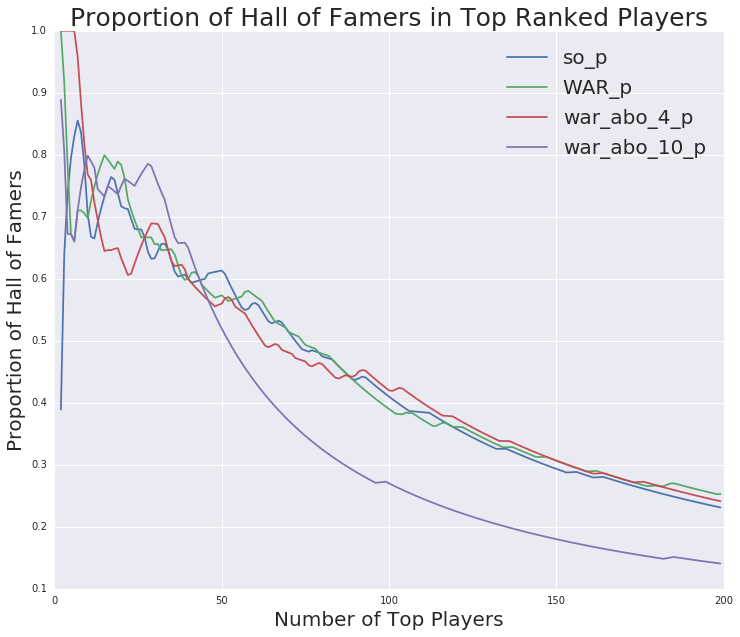

In [30]:
f, axarr = plt.subplots(1,1,figsize=(12,10));
for u,col in zip(np.argsort(rfc.feature_importances_)[::-1][:4],pitchers.columns[np.argsort(rfc.feature_importances_)[::-1][:4]+1]):
    sub = pitchers.iloc[:,[0,u+1]].sort_values(col,ascending=False)
    inds = pd.Series(np.array(range(1,len(sub)+1))[:200])
    running_prop = (sub.hall.cumsum()/np.array(range(1,len(sub)+1)).astype(float))[:200]
    axarr.plot(inds.rolling(3,center=True).mean(),running_prop.rolling(3,center=True).mean(),label=col)
    axarr.legend(prop={'size':20});
axarr.set_title('Proportion of Hall of Famers in Top Ranked Players',fontsize=25)
axarr.set_ylabel('Proportion of Hall of Famers',fontsize=20)
axarr.set_xlabel('Number of Top Players',fontsize=20);
plt.savefig('Pitchers_Importances.png')